LASSO REGRESSION


      Metric  ADMM Lasso  Decision Tree
0   Accuracy    0.891713       0.880663
1  Precision    0.500000       0.453704
2    ROC AUC    0.896783       0.713445


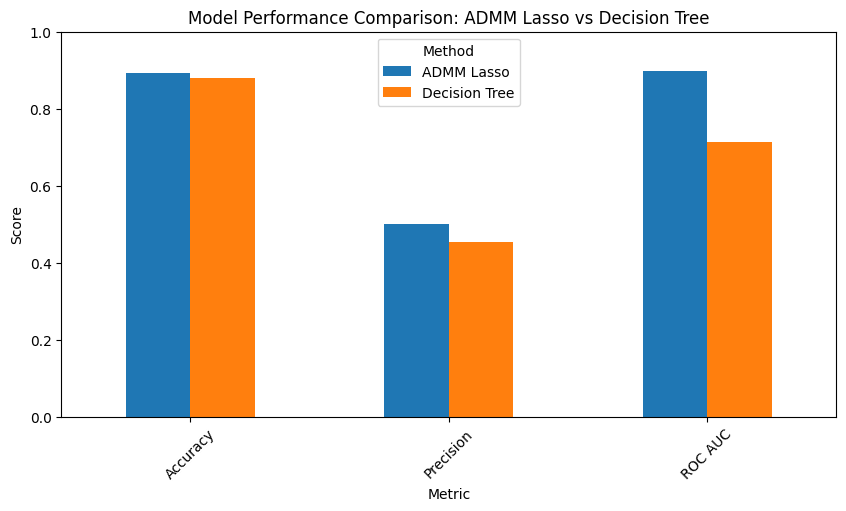

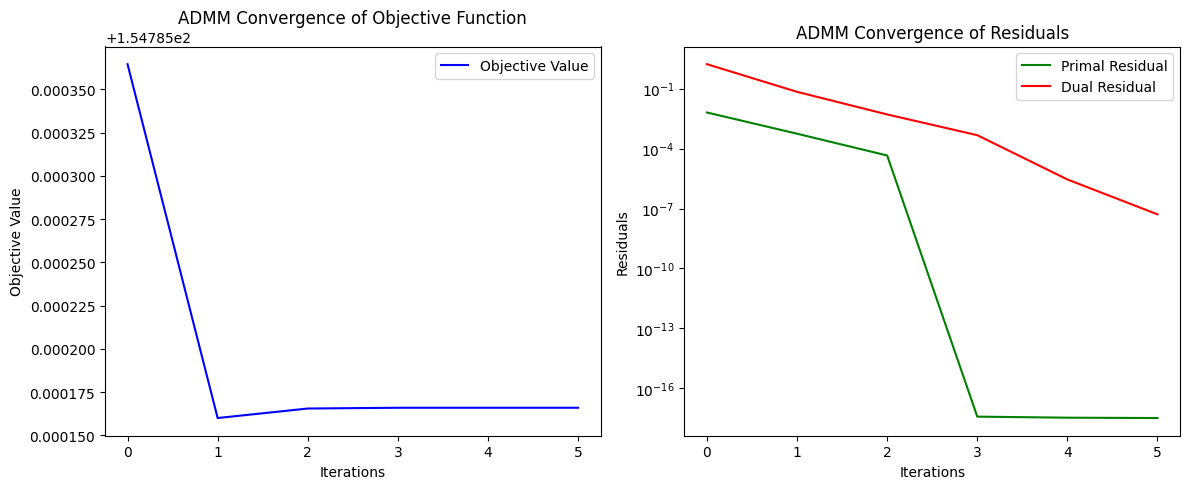

In [6]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_curve, auc, accuracy_score, precision_score)


data = pd.read_csv("Bank  Dataset - bank.csv")#dataset


data.replace("?", np.nan, inplace=True)
data.dropna(inplace=True)

X = pd.get_dummies(data.drop(columns=["y"]), drop_first=True).values.astype(float)
X = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-8)
y = data["y"].apply(lambda x: 1 if x == "yes" else 0).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def lasso_loss(X, y, w):
    return 0.5 * np.sum((X @ w - y) ** 2)

def soft_thresholding(x, threshold):
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

def lasso_regression_admm(X, y, lambda_param, rho=1.0, max_iter=1000, tol=1e-6):
    n, d = X.shape
    w = np.zeros(d)
    z = np.zeros(d)
    u = np.zeros(d)

    objective_vals = []
    primal_residuals = []
    dual_residuals = []

    for i in range(max_iter):
        w = np.linalg.solve(X.T @ X + rho * np.eye(d), X.T @ y + rho * (z - u))

        z_old = z.copy()
        z = soft_thresholding(w + u, lambda_param / rho)

        u = u + (w - z)

        primal_residual = np.linalg.norm(w - z)
        dual_residual = np.linalg.norm(rho * (z - z_old))
        objective_value = lasso_loss(X, y, w) + lambda_param * np.sum(np.abs(z))

        objective_vals.append(objective_value)
        primal_residuals.append(primal_residual)
        dual_residuals.append(dual_residual)


        if primal_residual < tol and dual_residual < tol:
            break

    return w, objective_vals, primal_residuals, dual_residuals


lambda_param = 0.01
rho = 10.0
w_admm, objective_vals_admm, primal_residuals_admm, dual_residuals_admm = lasso_regression_admm(X_train, y_train, lambda_param, rho)


y_scores_admm = X_test @ w_admm
y_pred_admm = (y_scores_admm >= 0.5).astype(int)

# Decision Tree 
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
y_scores_dt = dt.predict_proba(X_test)[:, 1]


def evaluate_model(y_true, y_pred, y_scores):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    roc_auc = auc(*roc_curve(y_true, y_scores)[:2])
    return accuracy, precision, roc_auc

metrics_admm = evaluate_model(y_test, y_pred_admm, y_scores_admm)#lasso

metrics_dt = evaluate_model(y_test, y_pred_dt, y_scores_dt)#decision tree

metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'ROC AUC'],
    'ADMM Lasso': metrics_admm,
    'Decision Tree': metrics_dt
})

print(metrics_df)

#plot graphs
metrics_df.set_index('Metric').plot(kind='bar', figsize=(10, 5))
plt.title('Model Performance Comparison: ADMM Lasso vs Decision Tree')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(title='Method')
plt.show()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(objective_vals_admm, label="Objective Value", color='blue')
plt.xlabel("Iterations")
plt.ylabel("Objective Value")
plt.title("ADMM Convergence of Objective Function")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(primal_residuals_admm, label="Primal Residual", color='green')
plt.plot(dual_residuals_admm, label="Dual Residual", color='red')
plt.xlabel("Iterations")
plt.ylabel("Residuals")
plt.title("ADMM Convergence of Residuals")
plt.yscale("log")
plt.legend()

plt.tight_layout()
plt.show()


